# **Collecting Data - Assignment 4**
## <font color=purple> **Working with past vs. present American Presidential Inaugurals** </font>

This assignment is based on the Corpus Analysis with spaCy by Megan S. Kane
https://programminghistorian.org/en/lessons/corpus-analysis-with-spacy (slightly adapted by Yevgen Matusevych for Collecting Data class at RUG) and (meta)data extraction from https://www.presidency.ucsb.edu/.

## <font color=green> **Part 1: SpaCy** </font>


### <font color=purple> **Installing, Importing and Preprocessing** </font>

In this assignment, we will analyze a corpus of 10 American Presidential Inaugural speeches. The corpus exists of the first five presidential inaugurals (1789, 1793, 1797, 1801, 1805) as well as the last five presidential inaugurals (2005, 2009, 2013, 2017, 2021). This collection lends itself for an analysis of potential change of the rhetorical genre of the presidential inaugural over time. The results can potentially demonstrate shifts in trends, as well as relevant topics in presidential discourse at the wake of a new administration entering the White House.

Before we continue the analysis, we will first install all the necessary libraries, make sure they are stored in usable variables, and then continue to look at different spaCy text enrichment and annotation functions.

In [1]:
# Install and import spacy and plotly.
!pip install spaCy
!pip install plotly
!pip install nbformat==5.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 1.1 MB/s eta 0:00:00
Reason for being yanked: Name generation process created inappropriate id values
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.9.2
    Uninstalling nbformat-5.9.2:
      Successfully uninstalled nbformat-5.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires nbformat>=5.2.0, but you have nbformat 5.1.2 which is incompatible.


In [2]:
# Import spacy
import spacy

# Install English language model
!spacy download en_core_web_sm

# Import os to upload documents and metadata
import os

# Load spaCy visualizer
from spacy import displacy

# Import pandas DataFrame packages
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Import graphing packages
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob


2024-01-19 11:07:57.254004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 11:07:57.254093: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 11:07:57.255785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 11:08:00.742309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Create empty lists for file names and contents
texts = []
file_names = []

# Iterate through each file in the folder
for _file_name in os.listdir('inaugural_txt_files'):
# Look for only text files
    if _file_name.endswith('.txt'):
    # Append contents of each text file to text list
        texts.append(open('inaugural_txt_files' + '/' + _file_name, 'r', encoding='utf-8').read())
        # Append name of each file to file name list
        file_names.append(_file_name)

In [4]:
# Create dictionary object associating each file name with its text
d = {'Filename':file_names,'Speech':texts}

In [5]:
# Turn dictionary into a dataframe
inaugural_df = pd.DataFrame(d)

In [6]:
inaugural_df.head()

,Filename,Speech
0,1793_George_Washington.txt,I AM again called upon by the voice of my coun...
1,2021_Joseph_Biden.txt,"Chief Justice Roberts, Vice President Harris, ..."
2,2005_George_W_Bush.txt,"\nVice President Cheney, Mr. Chief Justice, Pr..."
3,1801_Thomas_Jefferson.txt,Friends and Fellow-Citizens:\nCALLED upon to u...
4,1789_George_Washington.txt,Fellow-Citizens of the Senate and of the House...


Now we need to clean up the data in the speech column of the dataframe:

In [7]:
# Remove extra spaces from papers
inaugural_df['Speech'] = inaugural_df['Speech'].str.replace('\s+', ' ', regex=True).str.strip()
inaugural_df.head()

,Filename,Speech
0,1793_George_Washington.txt,I AM again called upon by the voice of my coun...
1,2021_Joseph_Biden.txt,"Chief Justice Roberts, Vice President Harris, ..."
2,2005_George_W_Bush.txt,"Vice President Cheney, Mr. Chief Justice, Pres..."
3,1801_Thomas_Jefferson.txt,Friends and Fellow-Citizens: CALLED upon to un...
4,1789_George_Washington.txt,Fellow-Citizens of the Senate and of the House...


And load and clean up the metadata:

In [8]:
# Load metadata.
metadata_df = pd.read_csv('President_Inaugural_Meta.csv')

In [9]:
# Remove .txt from title of each paper
inaugural_df['Filename'] = inaugural_df['Filename'].str.replace('.txt', '', regex=True)

# Rename column from file_name to Title
metadata_df.rename(columns={"file_name": "Filename"}, inplace=True)

In [143]:
metadata_df.head()

,Filename,name_president,president_no,date_of_inaugural
0,1789_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,April 30 1789
1,1793_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,March 04 1793
2,1797_John_Adams,John Adams,2nd President of the United States: 1797 _ 1801,March 04 1797
3,1801_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1801
4,1805_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1805


Next, we will merge the metadata as well as the speeches into a new DataFrame

In [11]:
# Will only keep rows where both speech and metadata are present
presidential_inaugural_df = metadata_df.merge(inaugural_df,on='Filename')

In [12]:
# Print DataFrame
presidential_inaugural_df.head()

,Filename,name_president,president_no,date_of_inaugural,Speech
0,1789_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,April 30 1789,Fellow-Citizens of the Senate and of the House...
1,1793_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,March 04 1793,I AM again called upon by the voice of my coun...
2,1797_John_Adams,John Adams,2nd President of the United States: 1797 _ 1801,March 04 1797,"WHEN it was first perceived, in early times, t..."
3,1801_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1801,Friends and Fellow-Citizens: CALLED upon to un...
4,1805_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1805,"PROCEEDING, fellow-citizens, to that qualifica..."


## <font color=purple> **Text Enrichment with SpaCy** </font>
#### **Creating Doc Objects**
To use spaCy, the first step is to load one of spaCy’s Trained Models and Pipelines which will be used to perform tokenization, part-of-speech tagging, and other text enrichment tasks.

In [13]:
# Load nlp pipeline
nlp = spacy.load('en_core_web_sm')

# Check what functions it performs
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [14]:
# Define a function that runs the nlp pipeline on any given input text
def process_text(text):
    return nlp(text)

In [15]:
# Apply the function to the "Text" column, so that the nlp pipeline is called on each speech
presidential_inaugural_df['Doc'] = presidential_inaugural_df['Speech'].apply(process_text)

### **Text Reduction**
#### **Tokenization**
The initial and crucial process carried out by spaCy is tokenization, which involves breaking down strings into individual words and punctuation marks. This facilitates spaCy in analyzing the grammatical structures of a text and recognizing features such as part-of-speech for each word.

To obtain a tokenized representation of each text in a DataFrame, we have to create a function that iterates through a given Doc object and extract all tokens it contains.

In [16]:
# Define a function to retrieve tokens from a doc object
def get_token(doc):
    return [(token.text) for token in doc]

In [17]:
# Run the token retrieval function on the doc objects in the dataframe
presidential_inaugural_df['Tokens'] = presidential_inaugural_df['Doc'].apply(get_token)
presidential_inaugural_df.head()

,Filename,name_president,president_no,date_of_inaugural,Speech,Doc,Tokens
0,1789_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,April 30 1789,Fellow-Citizens of the Senate and of the House...,"(Fellow, -, Citizens, of, the, Senate, and, of...","[Fellow, -, Citizens, of, the, Senate, and, of..."
1,1793_George_Washington,George Washington,1st President of the United States: 1789 _ 1797,March 04 1793,I AM again called upon by the voice of my coun...,"(I, AM, again, called, upon, by, the, voice, o...","[I, AM, again, called, upon, by, the, voice, o..."
2,1797_John_Adams,John Adams,2nd President of the United States: 1797 _ 1801,March 04 1797,"WHEN it was first perceived, in early times, t...","(WHEN, it, was, first, perceived, ,, in, early...","[WHEN, it, was, first, perceived, ,, in, early..."
3,1801_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1801,Friends and Fellow-Citizens: CALLED upon to un...,"(Friends, and, Fellow, -, Citizens, :, CALLED,...","[Friends, and, Fellow, -, Citizens, :, CALLED,..."
4,1805_Thomas_Jefferson,Thomas Jefferson,3rd President of the United States: 1801 _ 1809,March 04 1805,"PROCEEDING, fellow-citizens, to that qualifica...","(PROCEEDING, ,, fellow, -, citizens, ,, to, th...","[PROCEEDING, ,, fellow, -, citizens, ,, to, th..."


In [18]:
tokens = presidential_inaugural_df[['Speech', 'Tokens']].copy()
tokens.head()

,Speech,Tokens
0,Fellow-Citizens of the Senate and of the House...,"[Fellow, -, Citizens, of, the, Senate, and, of..."
1,I AM again called upon by the voice of my coun...,"[I, AM, again, called, upon, by, the, voice, o..."
2,"WHEN it was first perceived, in early times, t...","[WHEN, it, was, first, perceived, ,, in, early..."
3,Friends and Fellow-Citizens: CALLED upon to un...,"[Friends, and, Fellow, -, Citizens, :, CALLED,..."
4,"PROCEEDING, fellow-citizens, to that qualifica...","[PROCEEDING, ,, fellow, -, citizens, ,, to, th..."


####**Lemmatization**
Another process performed by spaCy is lemmatization, or the retrieval of the dictionary root word of each word. For researchers using keyword searches, lemmatization reduces noise and improves results.

We’ll perform a similar set of steps to those above to create a function to call the lemmas from the Doc object, then apply it to the Dataframe.



In [19]:
# Define a function to retrieve lemmas from a doc object
def get_lemma(doc):
    return [(token.lemma_) for token in doc]

# Run the lemma retrieval function on the doc objects in the dataframe
presidential_inaugural_df['Lemmas'] = presidential_inaugural_df['Doc'].apply(get_lemma)

In [20]:
print(f'"citizen" appears in the speech tokens column ' + str(presidential_inaugural_df['Tokens'].apply(lambda x: x.count('citizen')).sum()) + ' times.')
print(f'"citizen" appears in the lemmas column ' + str(presidential_inaugural_df['Lemmas'].apply(lambda x: x.count('citizen')).sum()) + ' times.')

"citizen" appears in the speech tokens column 4 times.
"citizen" appears in the lemmas column 47 times.


As expected, there are more instances of “citizen” in the Lemmas column, as the lemmatization process has grouped inflected word forms (citizens) into the base word “citizen.”

### **Text Annotation**
#### **Part of Speech Tagging**
We will now work on tagging parts of speech which will be useful for our analysis later.

The extraction of part-of-speech tags can be done similarly to lemmas. A function can be crafted to retrieve these tags from any given Doc object, and this function can be implemented for each Doc object within the DataFrame.

In [21]:
# Define a function to retrieve lemmas from a doc object
def get_pos(doc):
    #Return the coarse- and fine-grained part of speech text for each token in the doc
    return [(token.pos_, token.tag_) for token in doc]

# Define a function to retrieve parts of speech from a doc object
presidential_inaugural_df['POS'] = presidential_inaugural_df['Doc'].apply(get_pos)

We can now create a list of part-of-speech columns for further examination. The initial (coarse-grained) tag corresponds to broadly identifiable parts of speech like nouns, adjectives, or punctuation marks. In contrast, the second (fine-grained) category is more intricate and may pose challenges in interpretation.

In [22]:
# Create a list of part of speech tags
list(presidential_inaugural_df['POS'])

[[('PROPN', 'NNP'),
  ('PUNCT', 'HYPH'),
  ('PROPN', 'NNPS'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('PROPN', 'NNP'),
  ('CCONJ', 'CC'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('PROPN', 'NNP'),
  ('ADP', 'IN'),
  ('PROPN', 'NNPS'),
  ('PUNCT', ':'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('NOUN', 'NNS'),
  ('NOUN', 'NN'),
  ('ADP', 'IN'),
  ('NOUN', 'NN'),
  ('DET', 'DT'),
  ('NOUN', 'NN'),
  ('AUX', 'MD'),
  ('AUX', 'VB'),
  ('VERB', 'VBN'),
  ('PRON', 'PRP'),
  ('ADP', 'IN'),
  ('ADJ', 'JJR'),
  ('NOUN', 'NNS'),
  ('ADP', 'IN'),
  ('PRON', 'DT'),
  ('ADP', 'IN'),
  ('PRON', 'WDT'),
  ('DET', 'DT'),
  ('NOUN', 'NN'),
  ('AUX', 'VBD'),
  ('VERB', 'VBN'),
  ('ADP', 'IN'),
  ('PRON', 'PRP$'),
  ('NOUN', 'NN'),
  ('PUNCT', ','),
  ('CCONJ', 'CC'),
  ('VERB', 'VBD'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('ADJ', 'JJ'),
  ('NOUN', 'NN'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('ADJ', 'JJ'),
  ('NOUN', 'NN'),
  ('PUNCT', '.'),
  ('ADP', 'IN'),
  ('DET', 'DT'),
  ('NUM', 'CD'),
  ('NOUN', 'NN'),
  ('PUNCT

To know what each of these part of speech tags mean, we can use spaCy's built-in function called explain that can provide a short description of any tag of interest. Let's try it out:

In [23]:
spacy.explain("PROPN")

'proper noun'

[link text](https://)It is also possible to only retrieve a specific set of part-of-speech tags for in-depth analysis, such as isolating all proper nouns. To achieve this, we can write a function to selectively extract words tagged as proper nouns.

In [24]:
# Define function to extract proper nouns from Doc object
def extract_proper_nouns(doc):
    return [token.text for token in doc if token.pos_ == 'PROPN']

# Apply function to Doc column and store resulting proper nouns in new column
presidential_inaugural_df['Proper_Nouns'] = presidential_inaugural_df['Doc'].apply(extract_proper_nouns)

Listing the nouns in each text can help us ascertain the texts’ subjects. Let’s list the nouns in two different texts, namely the first and the last.

In [25]:
list(presidential_inaugural_df.loc[[0, 9], 'Proper_Nouns'])

[['Fellow',
  'Citizens',
  'Senate',
  'House',
  'Representatives',
  'Almighty',
  'United',
  'States',
  'Government',
  'Great',
  'Author',
  'Hand',
  'United',
  'States',
  'united',
  'President',
  'Heaven',
  'Heaven',
  'Constitution',
  'House',
  'Representatives',
  'Parent',
  'Human',
  'Race'],
 ['Chief',
  'Justice',
  'Roberts',
  'Vice',
  'President',
  'Harris',
  'Speaker',
  'Pelosi',
  'Leader',
  'Schumer',
  'Leader',
  'McConnell',
  'Vice',
  'President',
  'Pence',
  'Americans',
  'America',
  'America',
  'America',
  'Capitol',
  'God',
  'Constitution',
  'Nation',
  'President',
  'Carter',
  'George',
  'Washington',
  'Union',
  'America',
  'World',
  'War',
  'II',
  'America',
  'January',
  'New',
  'Year',
  'Abraham',
  'Lincoln',
  'Emancipation',
  'Proclamation',
  'President',
  'January',
  'America',
  'American',
  'America',
  'Civil',
  'War',
  'Great',
  'Depression',
  'World',
  'War',
  'United',
  'States',
  'America',
  'Am

In the last speech, many names of other politicans occur, which might imply that this is a more modern part of the genre of the inaugural adress.

#### **Named Entity Recognition**
spaCy can tag named entities in the text, such as names, dates, organizations, and locations. By calling upon these named-entities, we can facilitate an analysis of these entities.

Named entity recognition enables researchers to take a closer look at the ‘real-world objects’ that are present in their texts. The rendering allows for close-reading of these entities in context, their distinctions helpfully color-coded.

In [26]:
# Get all NE labels and assign to variable
labels = nlp.get_pipe("ner").labels

# Print each label and its description
for label in labels:
    print(label + ' : ' + spacy.explain(label))

CARDINAL : Numerals that do not fall under another type
DATE : Absolute or relative dates or periods
EVENT : Named hurricanes, battles, wars, sports events, etc.
FAC : Buildings, airports, highways, bridges, etc.
GPE : Countries, cities, states
LANGUAGE : Any named language
LAW : Named documents made into laws.
LOC : Non-GPE locations, mountain ranges, bodies of water
MONEY : Monetary values, including unit
NORP : Nationalities or religious or political groups
ORDINAL : "first", "second", etc.
ORG : Companies, agencies, institutions, etc.
PERCENT : Percentage, including "%"
PERSON : People, including fictional
PRODUCT : Objects, vehicles, foods, etc. (not services)
QUANTITY : Measurements, as of weight or distance
TIME : Times smaller than a day
WORK_OF_ART : Titles of books, songs, etc.


In [27]:
# Define function to extract named entities from doc objects
def extract_named_entities(doc):
    return [ent.label_ for ent in doc.ents]

# Apply function to Doc column and store resulting named entities in new column
presidential_inaugural_df['Named_Entities'] = presidential_inaugural_df['Doc'].apply(extract_named_entities)
presidential_inaugural_df['Named_Entities']

0    [ORG, ORG, DATE, DATE, DATE, DATE, ORDINAL, GP...
1                                           [GPE, LAW]
2    [ORDINAL, GPE, PERSON, ORDINAL, CARDINAL, EVEN...
3    [ORG, ORDINAL, DATE, LAW, CARDINAL, CARDINAL, ...
4    [LAW, ORG, ORG, NORP, GPE, ORG, GPE, LAW, ORG,...
5    [PERSON, PERSON, PERSON, PERSON, PERSON, ORG, ...
6    [DATE, PERSON, CARDINAL, NORP, ORG, GPE, NORP,...
7    [PERSON, PERSON, ORG, LAW, NORP, DATE, DATE, L...
8    [PERSON, PERSON, PERSON, PERSON, PERSON, NORP,...
9    [PERSON, PERSON, PERSON, PERSON, PERSON, NORP,...
Name: Named_Entities, dtype: object

In [28]:
# Define function to extract text tagged with named entities from doc objects
def extract_named_entities(doc):
    return [ent for ent in doc.ents]

# Apply function to Doc column and store resulting text in new column
presidential_inaugural_df['NE_Words'] = presidential_inaugural_df['Doc'].apply(extract_named_entities)
presidential_inaugural_df['NE_Words']

0    [(Fellow, -, Citizens, of, the, Senate), (the,...
1                          [(America), (Constitution)]
2    [(first), (America), (Providence), (first), (m...
3    [(Fellow, -, Citizens), (first), (this, day), ...
4    [(Constitution), (Commonwealth), (State), (Ame...
5    [(Cheney), (Chief, Justice), (Carter), (Bush),...
6    [(today), (Bush), (Forty, -, four), (Americans...
7    [(Biden), (Chief, Justice), (Congress), (Const...
8    [(Roberts), (Carter), (Clinton), (Bush), (Obam...
9    [(Roberts), (Harris), (Schumer), (McConnell), ...
Name: NE_Words, dtype: object

Now let’s visualize the words and their named entity tags in a the first inaugural speech given by President Washington in 1789.




In [29]:
# Extract the first Doc object
doc = presidential_inaugural_df['Doc'][0]

# Visualize named entity tagging in a single paper
displacy.render(doc, style='ent', jupyter=True)

The highlighted words in the text visualize the named entity tags in this speech, however, we should remain critical of how spaCy tags these entities, as the  output can contain incorrect tags.




### **Download Enriched Dataset**
We wil now save this new dataset including the doc objects, text reductions and linguistic annotations generated with spaCy as csv file.

In [30]:
# Use this step only to save csv to your computer's working directory
presidential_inaugural_df.to_csv('President_Inaugural_with_spaCy_tags.csv')

## <font color=green> **Part 2: Bonus** </font>

#### **EXTRA: Sentiment Analysis**
Using NLP techniques to determine the sentiment or emotional tone expressed in the selected inaugural adresses. The primary goal of sentiment analysis is to understand and interpret the subjective information conveyed in the text, and it is commonly used to assess whether the expressed sentiment is positive, negative, or neutral.

                 Filename  Sentiment
0  1789_George_Washington   0.204100
1  1793_George_Washington   0.012778
2         1797_John_Adams   0.172514
3   1801_Thomas_Jefferson   0.235479
4   1805_Thomas_Jefferson   0.124626
5      2005_George_W_Bush   0.177587
6       2009_Barack_Obama   0.085786
7       2013_Barack_Obama   0.130157
8       2017_Donald_Trump   0.165025
9       2021_Joseph_Biden   0.168686


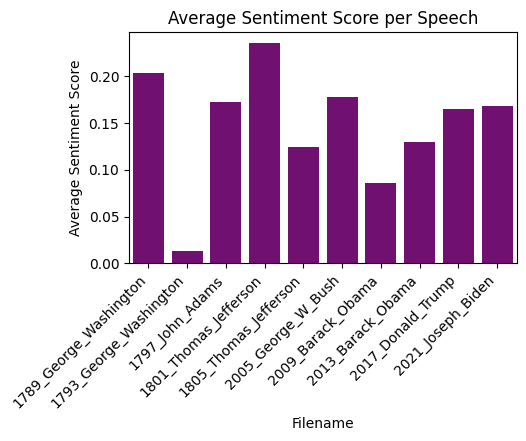

In [113]:
# Calculate the sentiment scores
presidential_inaugural_df['Sentiment'] = presidential_inaugural_df['Speech'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
# Calculate average sentiment scores
avg_sentiment_per_speech = presidential_inaugural_df.groupby('Filename')['Sentiment'].mean().reset_index()

# Print average sentiment scores per inaugural
print(avg_sentiment_per_speech)

## Plot the sentiment scores
plt.figure(figsize=(5, 3))
sns.barplot(x='Filename', y='Sentiment', data=avg_sentiment_per_speech, color='purple')
plt.title('Average Sentiment Score per Speech')
plt.xlabel('Filename')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.show()

The scores in a sentiment analysis lay between -1 and 1. Scording close to 1 indicates a positive sentiment score, 0 is considered a neutral score, whilst scoring close to -1 indicates a negative sentiment.

The table and graph above shows the average sentiment score for each presidential inaugural. Thomas Jefferson's 1805 address scores the highest, with a sentiment of 0.235479. Noticable too is the the dip for George Washington's second inaugural address. This inaugural scores 0.012778, indicating that his speech was very close to the neutral score. Overall, the speeches all appear very neutral, not scoring below 0, but not coming close to the score of 1 either.


Notacable about the dip in Washington's second address is that the speech itself was also very short in comparision to other speeches. This is visualized below:

##### **Inaugural Length**


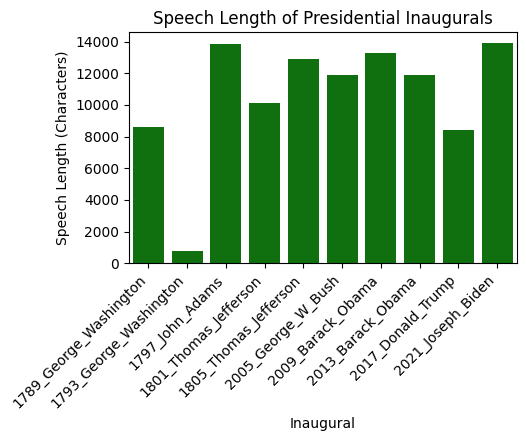

In [133]:
# Write a function to count characters
def count_characters(speech):
    return len(str(speech))

# Apply the function to our data
inaugural_length = presidential_inaugural_df['Speech'].apply(count_characters)

# Create a bar plot
plt.figure(figsize=(5, 3))
sns.barplot(x=presidential_inaugural_df['Filename'], y=inaugural_length, color='green')
plt.title('Speech Length of Presidential Inaugurals')
plt.xlabel('Inaugural')
plt.ylabel('Speech Length (Characters)')
plt.xticks(rotation=45, ha='right')
plt.show()

It immediately becomes very clear that Washinton's second address was short, especially in comparision to the other addresses. Let's visualize this in an even clearer way below.

 Visualizing this in in a pie chart will show us how the the lenght of the speeches is divided in relation to each other:

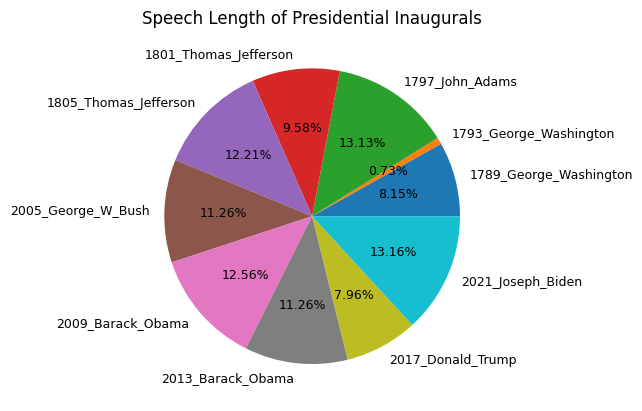

In [134]:
# Create a pie chart
plt.pie(x=inaugural_length, labels=presidential_inaugural_df['Filename'], autopct='%1.2f%%', textprops={'fontsize':9})
plt.title('Speech Length of Presidential Inaugurals')
plt.show()

The percentages show that most speeches are around the same length, each taking up between +/- 8% and +/- 13% space of the speeches in the corpus. As an outsider of the norm, George Washington's 1793 address only takes up 0.73%, showing his address was out of the norm in length.

#### **EXTRA: Keyword Analysis**

Below, you will find a visualization of the change over time of Christian related keywords in the Inaugural Addresses of the first five speeches vs. the five most recent ones.


In [135]:
# Make a list of Christian-related keywords
keywords = ['god', 'faith', 'prayer', 'pray', 'praying', 'bless', 'blessing', 'divine', 'providence', 'providential', 'moral', 'morality', 'supreme', 'heaven', 'almighty', 'saint', 'bible']

# Write a function to count the keywords in the corpus
def count_keywords(doc):
    total_tokens = len(doc)
    if total_tokens == 0:
        return 0
    return sum(token.text.lower() in keywords for token in doc) / total_tokens


In [137]:
# Apply function to presidential inaugurals
presidential_inaugural_df['Christian_Keyword_Frequency'] = presidential_inaugural_df['Doc'].apply(count_keywords)
# Count keywords per speech
keyword_by_speech = presidential_inaugural_df.groupby('Filename')['Christian_Keyword_Frequency'].sum()

# Create a bar plot
fig = px.bar(keyword_by_speech, x=keyword_by_speech.index, y='Christian_Keyword_Frequency', title="Frequency of Christian-related keywords in Presidential Inaugural Adresses 1789 - 1805 vs. 2005 - 2021)", labels={'Christian_Keyword_Frequency':'Frequency of Keywords', 'Filename':'Filename'})
fig.show()

The graph shows that in our selected corpus, George Washington in 1789 and Donald Trump in 2017, drew upon the most keywords we defined as being related to Christianity. In 1793, Washington did not draw upon any of these keywords at all. Jefferson in both his addresses, kept the reference to these words at similar height, scoring the lowest after Washington's second address.

#### **EXTRA: Word Frequency in Word Cloud**

In [138]:
#install the necessary packages
from wordcloud import WordCloud

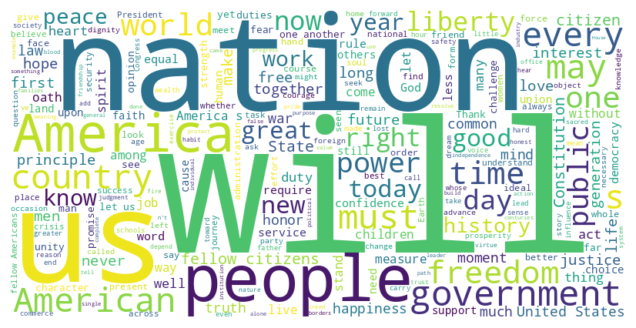

In [139]:
# Store tokens in variable
inaugural_tokens = presidential_inaugural_df['Tokens']

# Concatenate all speeches' tokens into a single string
all_speeches = ' '.join([' '.join(tokens) for tokens in inaugural_tokens])

# Create a WordCloud
# Setting the colormap to 'virids' helps improve graph readability for readers with common forms of color blindness and/or color vision deficiency.
wordcloud = WordCloud(background_color="white", width=800, height=400, max_words=250, colormap = 'viridis').generate(all_speeches)

# Display the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The wordcloud above shows us the most used-words in all the Inaugural Adresses in our corpus. The bigger the words appear, the more they were used. This shows us that words such as '**will**', '**nation**', '**us**', '**America**' and '**people**' were very popular to use in the American Presidential Inaugural, or at least, in our corpus of the first five and most recent five addresses.

To make the different analyses performed in this bonus section more representative, the different Inaugurals of all 46 presidents, should be analyzed.